In [1]:
import sys
from matplotlib import cm, colors, colorbar
!{sys.executable} -m pip install statannot
# Import MNE, as well as the MNE sample dataset
from mne import io
from mne.datasets import sample
from mne.viz import plot_topomap
from mne.time_frequency import psd_welch
from preprocess import process_eegs
from scipy.stats import ttest_ind
from statannot import add_stat_annotation
from teja_vae_cpd import teja_vae_cpd
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import TensorFox as tfx
import torch
import torch.nn as nn

In [2]:
full_psds, _, _, _, _, grade, epi_dx, alz_dx, _, _, _, _, raw_eegs = process_eegs(return_raw= True)
an_eegs = raw_eegs[(epi_dx<0) & (alz_dx<0)]
pop_psds= full_psds[(epi_dx<0) & (alz_dx<0)]
psds_min = torch.min(pop_psds)
psds_max = torch.max(pop_psds)

trans_psds = (pop_psds - psds_min)/(psds_max - psds_min)

In [3]:
ch_names = ['fp1', 'f3', 'f7', 'c3', 't7', 'p3', 'p7', 'o1', 
            'fp2', 'f4', 'f8', 'c4', 't8', 'p4', 'p8', 'o2',
            'fz', 'cz', 'pz']
ch_names = [ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp') for ch_name in ch_names]
ch_types = ['eeg'] * len(ch_names)
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=256)
info.set_montage('standard_1020')

def plot_factors(factors, d=3, factors_name=["Epochs", "Topomap", "Spectrum"]):

    rank = factors[0].shape[1]
    
    # sns.reset_orig()
    fig, all_axs = plt.subplots(rank, d, figsize=(12, int(rank * 2 + 1)))
    
    for ind, (factor, axs) in enumerate(zip(factors[:d], all_axs.T)):
        # axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            if ind == 0:
                sns.kdeplot(data=f, ax=ax)
            if ind == 1:
                mne.viz.plot_topomap(f, info, sensors=False, contours=0, cmap=cm.viridis, show=False, axes=ax)
            if ind == 2:
                sns.despine(top=True, ax=ax)
                ax.plot(f)
                ax.set_xlabel("Frequency (Hz)")
            all_axs[i, 0].set_ylabel("Factor " + str(i+1))
    fig.tight_layout()
    plt.show()

In [4]:
model = torch.load("../checkpoints/teja_vae_cp_epoch_85.pth") 
model.eval()
model.to("cpu")
trans_psds = trans_psds.to(torch.float32)
epoch_components, _, _ = model.encoder(trans_psds)
epoch_components = epoch_components.detach().cpu()
spatial_components = model.decoder.other_mus[0].detach().cpu()
frequency_components = model.decoder.other_mus[1].detach().cpu()

factors = [epoch_components, spatial_components, frequency_components]
tfx.change_sign(factors)
print()

In [5]:
min_indices = [] 
max_indices = []
for i in range(epoch_components.shape[1]):
    min_indices.append(torch.argmin(epoch_components[:,i]).item())
    max_indices.append(torch.argmax(epoch_components[:,i]).item())
print(min_indices)
print(max_indices)

[12353, 8298, 8298, 12673, 12673, 12416]
[12415, 12415, 12416, 12416, 12416, 12673]


In [6]:
# eeg_tensor = an_eegs[min_indices[5]]
# eeg_array = eeg_tensor#.numpy()
# num_channels = eeg_array.shape[0]
# fig, axs = plt.subplots(num_channels, 1, figsize=(10, 3*num_channels))
# for i in range(num_channels):
#     axs[i].plot(eeg_array[i, :])
#     axs[i].set_title('Channel {}'.format(ch_names[i]))
#     axs[i].set_xlabel('Time (samples)')
#     axs[i].set_ylabel('Amplitude')
# plt.tight_layout()
# plt.show()

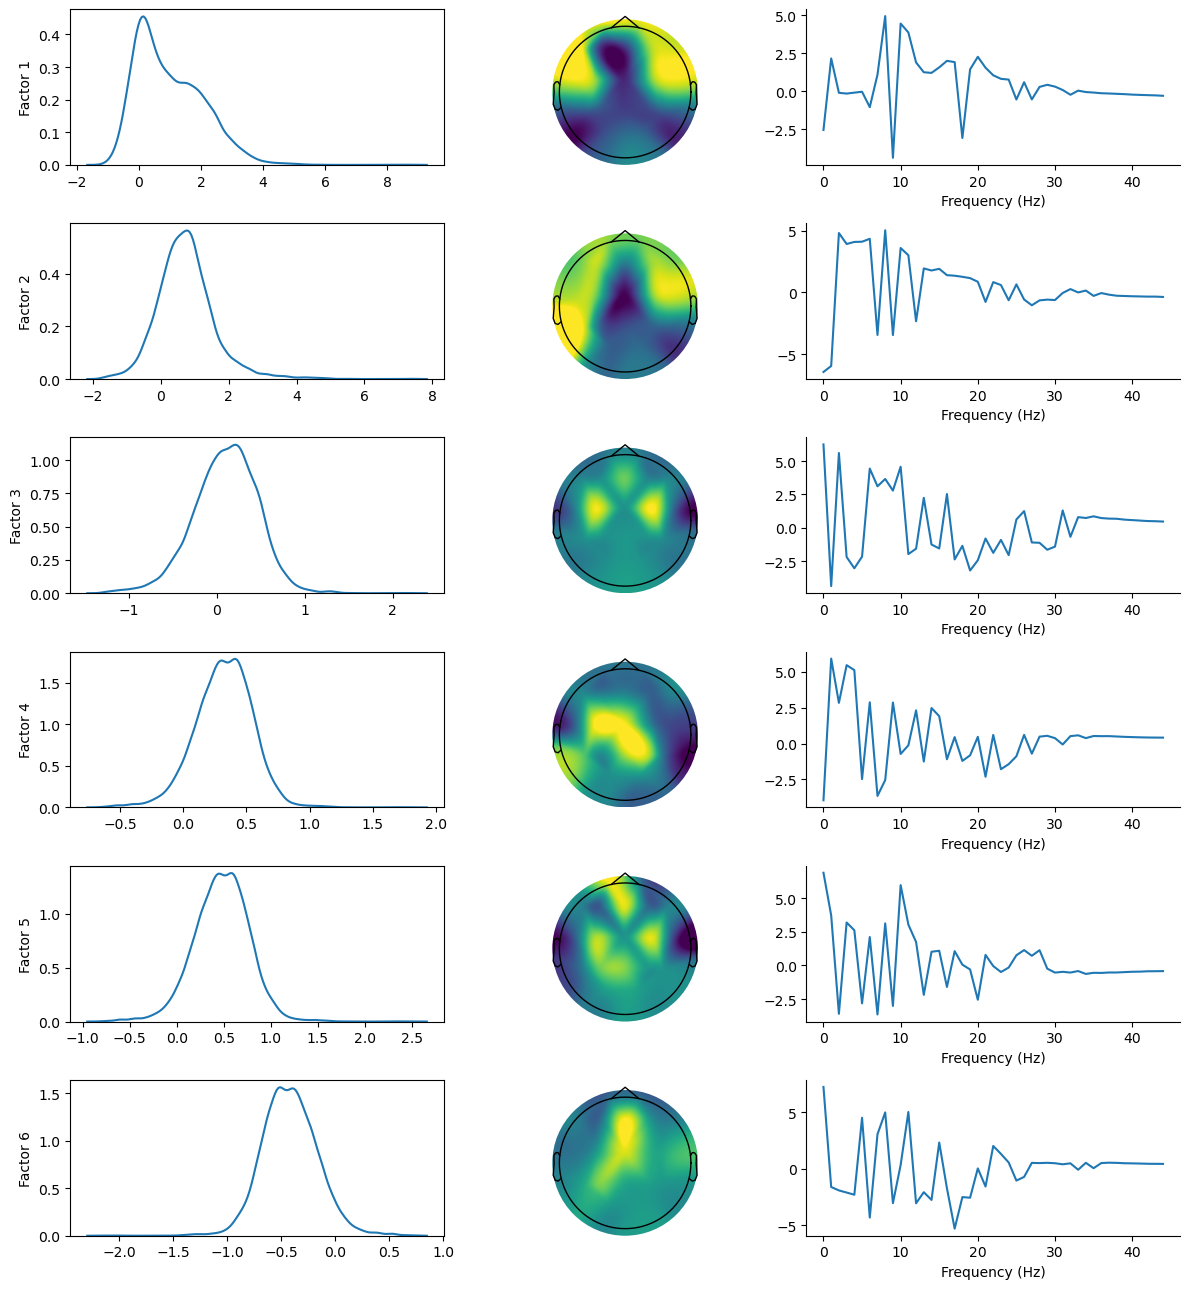

In [7]:
plot_factors(factors)

In [8]:
# _, _, _, _, _, grade, epi_dx, alz_dx, _, _, _, _ = process_eegs()

abnormal_vs_normal = grade[(epi_dx<0) & (alz_dx<0)]
print(abnormal_vs_normal.shape)

torch.Size([14052])


p-value for Factor 1: 0.0
['Abnormal' 'Abnormal' 'Abnormal' ... 'Normal' 'Normal' 'Normal']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Abnormal v.s. Normal: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=8.486e+01


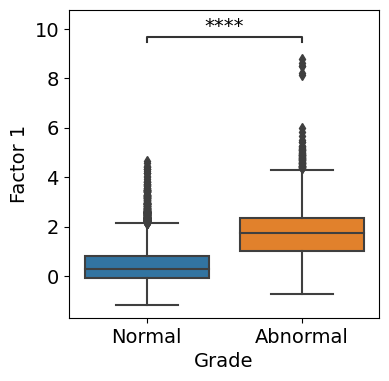

p-value for Factor 2: 5.987540382075944e-85
['Abnormal' 'Abnormal' 'Abnormal' ... 'Normal' 'Normal' 'Normal']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Abnormal v.s. Normal: t-test independent samples with Bonferroni correction, P_val=5.988e-85 stat=-1.966e+01


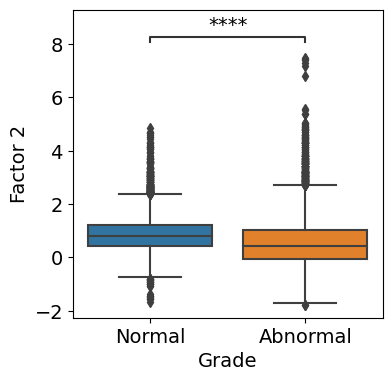

p-value for Factor 3: 7.379230065628408e-182
['Abnormal' 'Abnormal' 'Abnormal' ... 'Normal' 'Normal' 'Normal']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Abnormal v.s. Normal: t-test independent samples with Bonferroni correction, P_val=7.379e-182 stat=-2.919e+01


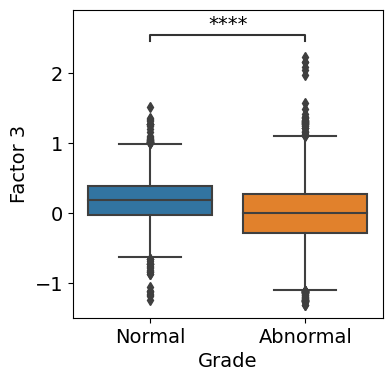

p-value for Factor 4: 3.403703212328207e-149
['Abnormal' 'Abnormal' 'Abnormal' ... 'Normal' 'Normal' 'Normal']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Abnormal v.s. Normal: t-test independent samples with Bonferroni correction, P_val=3.404e-149 stat=-2.633e+01


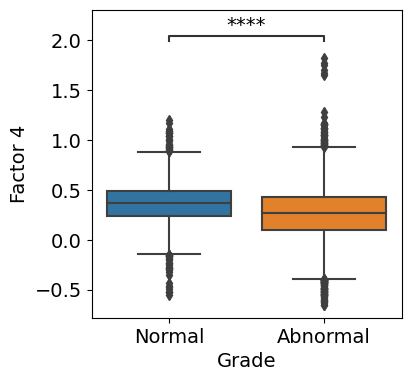

p-value for Factor 5: 7.045222299724079e-126
['Abnormal' 'Abnormal' 'Abnormal' ... 'Normal' 'Normal' 'Normal']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Abnormal v.s. Normal: t-test independent samples with Bonferroni correction, P_val=7.045e-126 stat=-2.411e+01


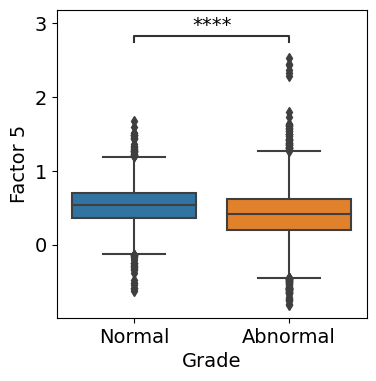

p-value for Factor 6: 3.369707707947507e-135
['Abnormal' 'Abnormal' 'Abnormal' ... 'Normal' 'Normal' 'Normal']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Abnormal v.s. Normal: t-test independent samples with Bonferroni correction, P_val=3.370e-135 stat=2.502e+01


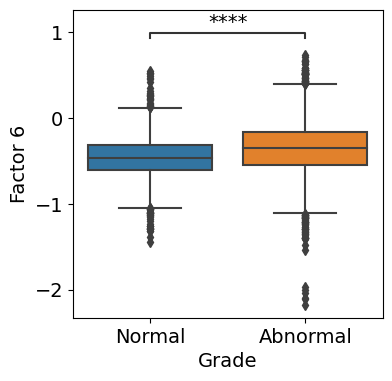

In [9]:
plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
rank = epoch_components.shape[1]
df = pd.DataFrame()
for i in range(rank):
    fig, ax = plt.subplots(1,1)
    x = np.array(abnormal_vs_normal[abnormal_vs_normal>=0])
    y = np.array(torch.flatten(epoch_components[:,i])[abnormal_vs_normal>=0])
    
    anormal = np.array(abnormal_vs_normal[abnormal_vs_normal>=0]).astype(str)
    anormal[anormal == '0'] = "Normal"
    anormal[anormal == '1'] = "Abnormal"
    
    df["Label"] = anormal
    df["Weights"] = y
    abnormal = torch.flatten(epoch_components[:,i])[abnormal_vs_normal == 1]
    normal = torch.flatten(epoch_components[:,i])[abnormal_vs_normal == 0]
    
    # df["Normal"] = normal
    # df["Abnormal"] = abnormal
    t_test = ttest_ind(abnormal, normal)
    print(f"p-value for Factor {i+1}: {t_test.pvalue}")
    sns.boxplot(df, x=x, y=y, ax=ax)
    print(anormal)
    test_results = add_stat_annotation(ax, data=df, x=anormal, y=y,
                                       box_pairs=[("Normal", "Abnormal")],
                                       test='t-test_ind', text_format='star', verbose=2)

    plt.xticks(np.arange(2), ['Normal', 'Abnormal'])

    ax.set_xlabel("Grade", {'fontsize' : 14})
    ax.set_ylabel(f"Factor {i+1}", {'fontsize' : 14})
    plt.show()